Overall Model - MAE: 8.93346354868789, RMSE: 226.76249586734755


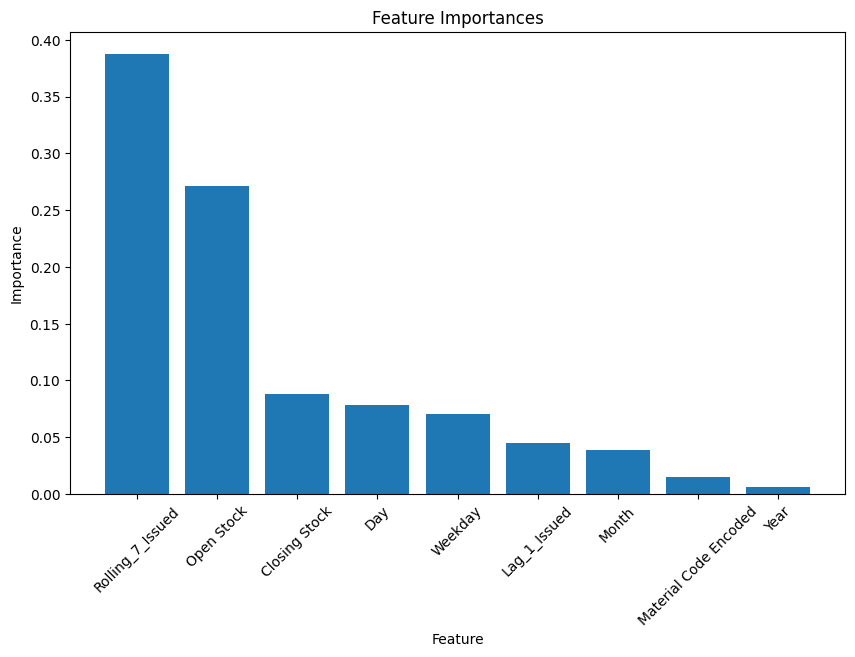

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import numpy as np

# Load the dataset
data = pd.read_csv('../data/combined_data.csv')

# Preprocessing
data['From Date'] = pd.to_datetime(data['From Date'], format="%d.%m.%Y")
data.sort_values('From Date', inplace=True)
data.rename(columns={
    'Material': 'Material Code',
    'Material Description': 'Material Description',
    'Opening Stock': 'Open Stock',
    'Total Issue Quantities': 'Material Issued',
    'Total Receipt Qties': 'Material Received',
    'Closing Stock': 'Closing Stock'
}, inplace=True)

# Drop unnecessary columns
data.drop(columns=['To Date', 'ValA', 'BUn'], inplace=True)

# Handle negative values in 'Material Issued'
data['Material Issued'] = data['Material Issued'].abs()

# Feature Engineering
data['Day'] = data['From Date'].dt.day
data['Month'] = data['From Date'].dt.month
data['Year'] = data['From Date'].dt.year

# Add 1-day Lag Feature
data['Lag_1_Issued'] = data.groupby('Material Code')['Material Issued'].shift(1)

# Add 7-day Rolling Statistics
data['Rolling_7_Issued'] = data.groupby('Material Code')['Material Issued'].rolling(7).mean().reset_index(level=0, drop=True)

# Add Seasonality Indicator (e.g., Weekday)
data['Weekday'] = data['From Date'].dt.weekday  # 0=Monday, 6=Sunday

# Fill NaN values introduced by lagging and rolling
data.fillna(0, inplace=True)

# Encode Material Code as a categorical feature
encoder = LabelEncoder()
data['Material Code Encoded'] = encoder.fit_transform(data['Material Code'])

# Target and Features
features = ['Open Stock', 'Closing Stock', 'Day', 'Month', 'Year', 'Material Code Encoded', 'Lag_1_Issued', 'Rolling_7_Issued', 'Weekday']
target = 'Material Issued'

# Prepare data for regression
X = data[features]
y = data[target]

# Time-based split
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Overall Model - MAE: {mae}, RMSE: {rmse}")

# Feature importance visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import numpy as np
import joblib

# Load your data (use your actual file path)
file_path = '../data/combined_data.csv'
data = pd.read_csv(file_path)

# Renaming the columns as per the user's mapping
data.rename(columns={
    'Material': 'Material Code',
    'Material Description': 'Material Description',
    'Opening Stock': 'Open Stock',
    'Total Issue Quantities': 'Material Issued',
    'Total Receipt Qties': 'Material Received',
    'Closing Stock': 'Closing Stock',
    'From Date': 'Date',
    'BUn': 'Unit'
}, inplace=True)

# Preprocessing
data['Date'] = pd.to_datetime(data['Date'], format="%d.%m.%Y")
data.sort_values('Date', inplace=True)
data = data.dropna(subset=['Material Issued', 'Open Stock', 'Closing Stock'])
data['Material Issued'] = data['Material Issued'].abs()

# Feature Engineering
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Add 1-day Lag Feature
data['Lag_1_Issued'] = data.groupby('Material Code')['Material Issued'].shift(1)

# Add 7-day Rolling Statistics
data['Rolling_7_Issued'] = data.groupby('Material Code')['Material Issued'].rolling(7).mean().reset_index(level=0, drop=True)

# Add Seasonality Indicator (e.g., Weekday)
data['Weekday'] = data['Date'].dt.weekday  # 0=Monday, 6=Sunday

# Fill NaN values introduced by lagging and rolling
data.fillna(0, inplace=True)

# Encode Material Code as a categorical feature
encoder = LabelEncoder()
data['Material Code Encoded'] = encoder.fit_transform(data['Material Code'])

# Target and Features
features = ['Open Stock', 'Closing Stock', 'Day', 'Month', 'Year', 'Material Code Encoded', 'Lag_1_Issued', 'Rolling_7_Issued', 'Weekday']
X = data[features]
y = data['Material Issued']

# Create MLflow experiment
experiment_name = "Hyperparameter Tuning with Optuna (RandomForest)"
experiment_id = mlflow.create_experiment(name=experiment_name)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)

    # Define model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=tscv)
    rmse = np.sqrt(-scores.mean())

    # Log parameters and metrics to MLflow
    with mlflow.start_run(experiment_id=experiment_id, nested=True):  # Reference the experiment
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)
        mlflow.log_metric("rmse", rmse)

    return rmse

# Suppress experimental warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run Optuna optimization
study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db")
study.optimize(objective, n_trials=50)

# Best trial results
best_params = study.best_params
print("Best Parameters:", best_params)

# Train and evaluate the best model
best_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

# Time-based split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Best Model RMSE: {rmse}")

# Save the model as a .pkl file
model_path = "best_random_forest_model.pkl"
joblib.dump(best_model, model_path)

# Log the best model to MLflow
with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_params(best_params)
    mlflow.log_metric("final_rmse", rmse)
    mlflow.log_artifact(model_path, artifact_path="models")

print("Hyperparameter tuning and logging to specified experiment complete.")

Best Parameters: {'n_estimators': 359, 'max_depth': 5, 'min_samples_split': 6}
Best Model RMSE: 222.3931077661056
Hyperparameter tuning and logging to specified experiment complete.


In [7]:
import json

# Save best_params to a JSON file
with open('best_params_rf.json', 'w') as json_file:
    json.dump(best_params, json_file)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import numpy as np
import joblib
import time

# Start timing
start_time = time.time()

# Load your data (use your actual file path)
file_path = '../data/inventory.csv'
data = pd.read_csv(file_path)

data = data[data['Type'] == 'Material']
data['Date'] = pd.to_datetime(data['Date'])
data['Material Code'] = data['Material Code'].astype(str)

# Preprocessing
data.sort_values('Date', inplace=True)
data = data.dropna(subset=['Material Issued', 'Open Stock', 'Closing Stock'])
data['Material Issued'] = data['Material Issued'].abs()

# Feature Engineering
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Add 1-day Lag Feature
data['Lag_1_Issued'] = data.groupby('Material Code')['Material Issued'].shift(1)

# Add 7-day Rolling Statistics
data['Rolling_7_Issued'] = data.groupby('Material Code')['Material Issued'].rolling(7).mean().reset_index(level=0, drop=True)

# Add Seasonality Indicator (e.g., Weekday)
data['Weekday'] = data['Date'].dt.weekday  # 0=Monday, 6=Sunday

# Fill NaN values introduced by lagging and rolling
data.fillna(0, inplace=True)

# Encode Material Code as a categorical feature
encoder = LabelEncoder()
data['Material Code Encoded'] = encoder.fit_transform(data['Material Code'])

# Target and Features
features = ['Open Stock', 'Closing Stock', 'Day', 'Month', 'Year', 'Material Code Encoded', 'Lag_1_Issued', 'Rolling_7_Issued', 'Weekday', 'BFP']
X = data[features]
y = data['Material Issued']


# Set up MLflow
mlflow.set_tracking_uri("sqlite:///mlruns.db")

# Create MLflow experiment
experiment_name = "Hyperparameter Tuning with Optuna (RandomForest - Material)"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(name=experiment_name)
else:
    experiment_id = experiment.experiment_id

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)

    # Define model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=tscv)
    rmse = np.sqrt(-scores.mean())

    # Log parameters and metrics to MLflow
    with mlflow.start_run(experiment_id=experiment_id, nested=True):  # Reference the experiment
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)
        mlflow.log_metric("rmse", rmse)

    return rmse

# Suppress experimental warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run Optuna optimization
study = optuna.create_study(study_name=experiment_name, direction="minimize", storage="sqlite:///optuna.db", load_if_exists=True)
study.optimize(objective, n_trials=50)

# Best trial results
best_params = study.best_params
print("Best Parameters:", best_params)

# Train and evaluate the best model
best_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

# Time-based split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Best Model RMSE: {rmse}")

# Save the model as a .pkl file
model_path = "best_random_forest_model_material.pkl"
joblib.dump(best_model, model_path)

# End timing
end_time = time.time()
runtime = end_time - start_time

# Log the best model to MLflow
with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_params(best_params)
    mlflow.log_metric("final_rmse", rmse)
    mlflow.log_metric("runtime", runtime)
    mlflow.log_artifact(model_path, artifact_path="models")

print("Hyperparameter tuning and logging to specified experiment complete.")
print(f"Total runtime: {runtime} seconds")


Best Parameters: {'n_estimators': 77, 'max_depth': 5, 'min_samples_split': 7}
Best Model RMSE: 233.77026414465402
Hyperparameter tuning and logging to specified experiment complete.
Total runtime: 23133.62515616417 seconds


In [ ]:
import json

# Save best_params to a JSON file
with open('best_params_rf_material.json', 'w') as json_file:
    json.dump(best_params, json_file)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import numpy as np
import joblib
import time

# Start timing
start_time = time.time()

# Load your data (use your actual file path)
file_path = '../data/inventory.csv'
data = pd.read_csv(file_path)

data = data[data['Type'] == 'Material']
data['Date'] = pd.to_datetime(data['Date'])
data['Material Code'] = data['Material Code'].astype(str)

# Preprocessing
data.sort_values('Date', inplace=True)
data = data.dropna(subset=['Material Issued', 'Open Stock', 'Closing Stock', 'Price'])

# Calculate Amount Issued and Amount Received
data['Amount Issued'] = data['Price'] * data['Material Issued']
data['Amount Received'] = data['Price'] * data['Material Received']

# Feature Engineering
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Quarter'] = data['Date'].dt.quarter

# Add 1-day Lag Feature
data['Lag_1_Issued'] = data.groupby('Material Code')['Material Issued'].shift(1)
data['Lag_1_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].shift(1)

# Add 7-day Rolling Statistics
data['Rolling_7_Issued'] = data.groupby('Material Code')['Material Issued'].rolling(7).mean().reset_index(level=0, drop=True)
data['Rolling_7_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].rolling(7).mean().reset_index(level=0, drop=True)

# Add Seasonality Indicator (e.g., Weekday)
data['Weekday'] = data['Date'].dt.weekday  # 0=Monday, 6=Sunday

# Cumulative Features
data['Cumulative_Issued'] = data.groupby('Material Code')['Material Issued'].cumsum()
data['Cumulative_Received'] = data.groupby('Material Code')['Material Received'].cumsum()
data['Cumulative_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].cumsum()

# Interaction Features
data['Price_Issued_Interaction'] = data['Price'] * data['Material Issued']

# Fill NaN values introduced by lagging and rolling
data.fillna(0, inplace=True)

# Encode Material Code as a categorical feature
encoder = LabelEncoder()
data['Material Code Encoded'] = encoder.fit_transform(data['Material Code'])

# One-hot encode Month and Quarter
data = pd.get_dummies(data, columns=['Month', 'Quarter'], drop_first=True)

# Target and Features
features = ['Open Stock', 'Closing Stock', 'Day', 'Year', 'Material Code Encoded', 'Lag_1_Issued', 'Rolling_7_Issued', 'Weekday', 'BFP', 'Lag_1_Amount_Issued', 'Rolling_7_Amount_Issued', 'Cumulative_Issued', 'Cumulative_Received', 'Cumulative_Amount_Issued', 'Price_Issued_Interaction'] + [col for col in data.columns if col.startswith('Month_') or col.startswith('Quarter_')]
X = data[features]
y = data['Material Issued']

# Set up MLflow
mlflow.set_tracking_uri("sqlite:///mlruns.db")

# Create MLflow experiment
experiment_name = "Hyperparameter Tuning with Optuna (RandomForest - Material - Added Features)"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(name=experiment_name)
else:
    experiment_id = experiment.experiment_id

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)

    # Define model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=tscv)
    rmse = np.sqrt(-scores.mean())

    # Log parameters and metrics to MLflow
    with mlflow.start_run(experiment_id=experiment_id, nested=True):  # Reference the experiment
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)
        mlflow.log_metric("rmse", rmse)

    return rmse

# Suppress experimental warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run Optuna optimization
study = optuna.create_study(study_name=experiment_name, direction="minimize", storage="sqlite:///optuna.db", load_if_exists=True)
study.optimize(objective, n_trials=50)

# Best trial results
best_params = study.best_params
print("Best Parameters:", best_params)

# Train and evaluate the best model
best_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

# Time-based split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Best Model RMSE: {rmse}")

# Save the model as a .pkl file
model_path = "best_random_forest_model_material_added_features.pkl"
joblib.dump(best_model, model_path)

# End timing
end_time = time.time()
runtime = end_time - start_time

# Log the best model to MLflow
with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_params(best_params)
    mlflow.log_metric("final_rmse", rmse)
    mlflow.log_metric("runtime", runtime)
    mlflow.log_artifact(model_path, artifact_path="models")

print("Hyperparameter tuning and logging to specified experiment complete.")
print(f"Total runtime: {runtime} seconds")


Best Parameters: {'n_estimators': 216, 'max_depth': 34, 'min_samples_split': 2}
Best Model RMSE: 93.8291164299235
Hyperparameter tuning and logging to specified experiment complete.
Total runtime: 52518.90888810158 seconds


In [5]:
import json

# Save best_params to a JSON file
with open('best_params_rf_material_added_features.json', 'w') as json_file:
    json.dump(best_params, json_file)